In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os
import subprocess
import inspect

import math
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset

import itertools

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines
from matplotlib.patches import Patch

from src.depth import DepthPoset
from src import depth_poset_similarity_scores

from tqdm import tqdm
from src.profiling import Timer

# Load and Format the Data

## Define Directories

In [3]:
# the directory to save pictures
path_to_save = 'raports/pics/torus-transpositions-extended'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [4]:
# the directory to load transpositions data
directory = "results/transpositions-during-linear-homotopy-between-extended-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

## Check sizes of files

In [5]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_193399/3943854577.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 36/36 [00:00<00:00, 190.62it/s]


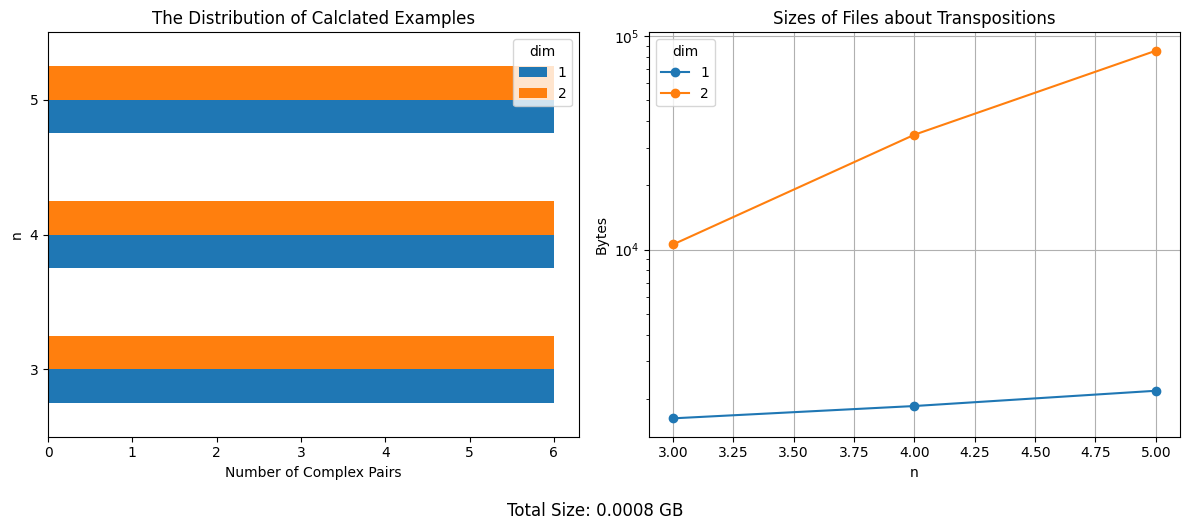

In [6]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

## Load Transpositions Data

In [7]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 36/36 [00:00<00:00, 1227.17it/s]

df.shape = (8608, 18)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,death_relation_cell_similarity,poset_closure_arcs_cell_similarity,poset_reduction_arcs_cell_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-07-15 15:04:04.174935,2025-07-15 15:04:04.175693,1,3,"(3,)",0.478046,1.210488,1.0,1.0,1.0,1.0,4,5,"((0,), (1,))","((1,), (2,))",1,death-death,no switch
1,2025-07-15 15:04:04.174935,2025-07-15 15:04:04.175693,1,3,"(3,)",0.618986,0.393119,1.0,1.0,1.0,1.0,2,3,"((0,),)","((2,),)",0,birth-birth,no switch
2,2025-07-15 15:04:04.174935,2025-07-15 15:04:04.175693,1,3,"(3,)",0.630475,0.382548,1.0,1.0,1.0,1.0,1,2,"((1,),)","((2,),)",0,birth-death,switch forward
3,2025-07-15 15:04:04.174935,2025-07-15 15:04:04.175693,1,3,"(3,)",0.640053,0.385960,1.0,0.0,0.0,0.0,2,3,"((1,),)","((0,),)",0,birth-birth,no switch
0,2025-07-15 15:04:04.174935,2025-07-15 15:04:04.205273,1,3,"(3,)",0.251474,1.220874,1.0,1.0,1.0,1.0,4,5,"((0,), (1,))","((1,), (2,))",1,death-death,no switch


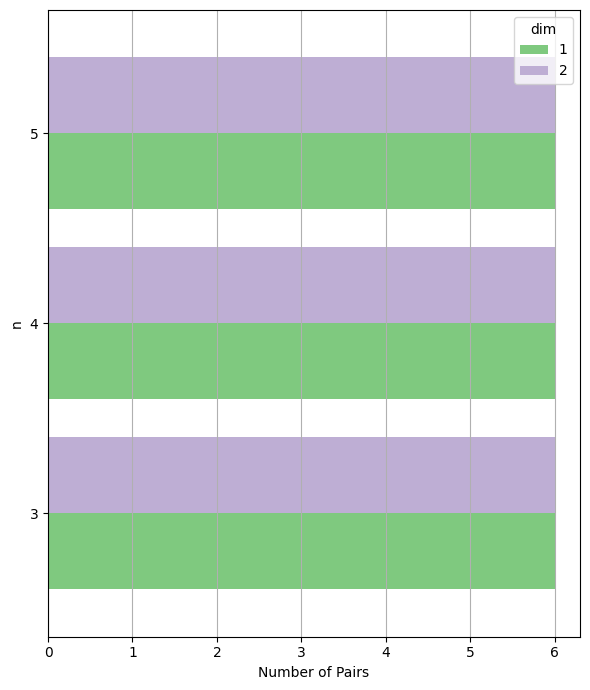

In [8]:
fig, ax = plt.subplots(figsize=(6, 7))


cmap_categorical = plt.get_cmap('Dark2')
cmap_categorical = plt.get_cmap('Accent')
colors = cmap_categorical(np.arange(df['complex_dim'].nunique()))


df_to_plot = df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n'])['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().rename(columns=lambda s: s.replace('complex_', '')).pivot_table(columns='dim', index='n', values='index0').fillna(0).astype(int)
df_to_plot.plot(kind='barh', color=colors, width=0.8, ax=ax)

ax.set_xlabel('Number of Pairs')

xticks = ax.get_xticks()
xticks = np.unique(np.append(xticks[xticks <= df_to_plot.max().max()], df_to_plot.max().max())).astype(int)

ax.set_xticks(xticks)

ax.grid(axis='x')

plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'distribution.png'))

# Switch Types Distribution

In [9]:
tqdm.pandas(desc="Define switch type from type and switch columns")
df['switch type'] = df.progress_apply(lambda row: row['type'] if row['switch'] in ['switch', 'switch backward', 'switch forward'] else row['switch'], axis=1)

df['switch type'].value_counts()

Define switch type from type and switch columns: 100%|██████████| 8608/8608 [00:00<00:00, 131893.65it/s]


switch type
no switch      7623
birth-birth     396
death-death     297
birth-death     292
Name: count, dtype: int64

In [10]:
# define colors and markers
switch_type_colors = pd.Series({
    'no switch': '#000000',    # black
    'birth-birth': '#0072B2',  # blue (CUD-safe)
    'birth-death': '#E69F00',  # orange (CUD-safe)
    'death-death': '#CC79A7',  # purple/pinkish (CUD-safe)
}, name='color')
switch_type_markers = pd.Series({
    'no switch': 'o',
    'birth-birth': '^',
    'birth-death': 'X',
    'death-death': 'v',
}, name='marker')

pd.DataFrame([switch_type_colors, switch_type_markers])

,no switch,birth-birth,birth-death,death-death
color,#000000,#0072B2,#E69F00,#CC79A7
marker,o,^,X,v


In [11]:
df_switch_types = df.copy()

with Timer() as timer:
    df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
    print(f'Calculated counts-values for each type in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    
    df_switch_types_mean = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
    df_switch_types_mean = df_switch_types_mean.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_mean.index.name = 'n'
    print(f'Calculated mean count in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    

    df_switch_types_std = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].std().reset_index()
    df_switch_types_std = df_switch_types_std.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_std.index.name = 'n'
    print(f'Calculated variation count in {timer.elapsed():.4f} seconds.')

df_switch_types_mean = df_switch_types_mean.sort_index(axis=1)
df_switch_types_std = df_switch_types_std.sort_index(axis=1)

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

print()
print(f'df_switch_types_std.shape = {df_switch_types_std.shape}')
print('...\n')
print(f'df_switch_types_mean.shape = {df_switch_types_mean.shape}')
df_switch_types_mean.head()


Calculated counts-values for each type in 0.0049 seconds.
Calculated mean count in 0.0069 seconds.
Calculated variation count in 0.0046 seconds.

df_switch_types_std.shape = (3, 16)
...

df_switch_types_mean.shape = (3, 16)


complex_dim           1                                                \
dim                   0                                 1               
switch type birth-birth birth-death no switch birth-death death-death   
n                                                                       
3                  1.00         1.2  1.250000    1.000000         NaN   
4                  1.25         1.4  1.333333    1.250000         1.5   
5                  3.00         1.2  3.166667    1.333333         1.5   

complex_dim                     2                                      \
dim                             0                                   1   
switch type no switch birth-birth birth-death   no switch birth-birth   
n                                                                       
3            1.250000    2.666667    1.000000   13.333333    8.333333   
4            1.166667    5.200000    2.000000   50.333333   14.000000   
5            2.166667   10.000000    2.833333  152.666667   25.166667   

complex_dim                                                              \
dim                                                       2               
switch type birth-death death-death   no switch birth-death death-death   
n                                                                         
3              4.666667    4.500000   55.666667    1.800000    2.166667   
4             10.666667    8.166667  227.333333    1.600000    5.000000   
5             16.500000   18.666667  558.666667    2.666667    9.000000   

complex_dim              
dim                      
switch type   no switch  
n                        
3             15.500000  
4             49.333333  
5            138.166667

In [12]:
pictypes_filename_template = 'transposition-types-complex-dim{complex_dim}-subposet-dim{dim}-drop-no-switches-{drop_no_switch}.png'

In [13]:
for irow, row in df_switch_types_mean.columns.to_frame()[['complex_dim', 'dim']].drop_duplicates().reset_index(drop=True).iterrows():
    complex_dim, dim = row
    for drop_no_switch in np.arange(2).astype(bool):
        row['drop_no_switch'] = drop_no_switch
        path = os.path.join(path_to_save, pictypes_filename_template.format(**row))
        df_this_mean = df_switch_types_mean[complex_dim][dim]
        df_this_std = df_switch_types_std[complex_dim][dim]

        if drop_no_switch:
            df_this_mean = df_this_mean.drop(columns='no switch')
            df_this_std = df_this_std.drop(columns='no switch')

        assert df_this_mean.columns.to_list() == df_this_std.columns.to_list()
        assert df_this_mean.index.to_list() == df_this_std.index.to_list()
        
        for col in df_this_mean.columns:
            x = df_this_mean.index.values
            y_mean = df_this_mean[col].values
            y_std = df_this_std[col].values
            plt.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
            plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

        plt.grid(True)
        plt.legend()
        plt.xlabel('$n$')
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

In [14]:
figure_2_layers_template = r"""
\begin{{figure}}[htbp]
\centering
{level0}
\vspace{{0.5cm}}
{level1}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

subfigure_template = r"""
\begin{{subfigure}}[b]{{{figwidth}\textwidth}}
    \includegraphics[width=\linewidth]{{{path}}}
    \caption{{{caption}}}
    \label{{{label}}}
\end{{subfigure}}
""".strip()


In [15]:
typedistribution_prefix_template = """
\\par The distribution of transpositions types for the model $\\mathbb{{T}}^{{{complex_dim}}}_n$ we can see in the figure Fig. \\ref{{{label}}}.
"""

In [16]:
switch_type_distributions_ltx = []

for complex_dim in pd.unique(df_switch_types['complex_dim']):
    

    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures_level0 = []
    subfigures_level1 = []
    
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, pictypes_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=False))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:complex{complex_dim}cells{dim}'
        subfigures_level0.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))

        path = os.path.join(path_to_save, pictypes_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=True))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim} (without no switch transpositions)"
        label = f'fig:complex{complex_dim}cells{dim}onlyswitch'
        subfigures_level1.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    level0 = '\n\\hfill\n'.join(subfigures_level0)
    level1 = '\n\\hfill\n'.join(subfigures_level1)
    caption = f'The switch type distribution for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = 'fig:' + f'typesdistribution{complex_dim}'
    
    text0 = typedistribution_prefix_template.format(complex_dim=complex_dim, label=label)
    text1 = figure_2_layers_template.format(level0=level0, level1=level1, caption=caption, label=label)
    switch_type_distributions_ltx.append(text0 + text1)

switch_type_distributions_ltx = '\n\n'.join(switch_type_distributions_ltx)
print(switch_type_distributions_ltx)


\par The distribution of transpositions types for the model $\mathbb{T}^{1}_n$ we can see in the figure Fig. \ref{fig:typesdistribution1}.
\begin{figure}[htbp]
\centering
\begin{subfigure}[b]{0.45\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim1-subposet-dim0-drop-no-switches-False.png}
    \caption{Cells dimension 0}
    \label{fig:complex1cells0}
\end{subfigure}
\hfill
\begin{subfigure}[b]{0.45\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim1-subposet-dim1-drop-no-switches-False.png}
    \caption{Cells dimension 1}
    \label{fig:complex1cells1}
\end{subfigure}
\vspace{0.5cm}
\begin{subfigure}[b]{0.45\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim1-subposet-dim0-drop-no-switches-True.png}
    \caption{Cells dimension 0 (without no switch transpositions)}
    \label{fig:complex1c

# Similarity Scores

In [17]:
scores = df.columns.values
scores = scores[np.isin(scores, [name for name, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction)])]
scores = scores.tolist()
scores

['birth_relation_cell_similarity',
 'death_relation_cell_similarity',
 'poset_closure_arcs_cell_similarity',
 'poset_reduction_arcs_cell_similarity']

In [18]:
df[['complex_dim', 'complex_n'] + scores].groupby(['complex_dim', 'complex_n']).count()

birth_relation_cell_similarity  \
complex_dim complex_n                                   
1           3                                      20   
            4                                      35   
            5                                      58   
2           3                                     654   
            4                                    2235   
            5                                    5606   

                       death_relation_cell_similarity  \
complex_dim complex_n                                   
1           3                                      20   
            4                                      35   
            5                                      58   
2           3                                     654   
            4                                    2235   
            5                                    5606   

                       poset_closure_arcs_cell_similarity  \
complex_dim complex_n                                       
1           3                                          20   
            4                                          35   
            5                                          58   
2           3                                         654   
            4                                        2235   
            5                                        5606   

                       poset_reduction_arcs_cell_similarity  
complex_dim complex_n                                        
1           3                                            20  
            4                                            35  
            5                                            58  
2           3                                           654  
            4                                          2235  
            5                                          5606

In [19]:
df_scores_mean = df[['complex_dim', 'complex_n', 'dim', 'switch type'] + scores].groupby(['complex_dim', 'complex_n', 'dim', 'switch type']).mean()
df_scores_std = df[['complex_dim', 'complex_n', 'dim', 'switch type'] + scores].groupby(['complex_dim', 'complex_n', 'dim', 'switch type']).std()

def regroup_df(df):
    df = df.reset_index(drop=False)
    df = df.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=scores, var_name='score', value_name='value')
    df = df.pivot_table(index='complex_n', columns=['score', 'complex_dim', 'dim', 'switch type'], values='value')
    return df

df_scores_mean = regroup_df(df_scores_mean)
df_scores_std = regroup_df(df_scores_std)

print(f'df_scores_mean.shape = {df_scores_mean.shape}')
print(f'df_scores_std.shape = {df_scores_std.shape}')

assert (df_scores_mean.columns == df_scores_std.columns).all()
assert (df_scores_mean.index == df_scores_std.index).all()

nrows = min(5, len(df_scores_mean))
pd.concat([df_scores_mean.head(nrows), df_scores_std.head(nrows)])

df_scores_mean.shape = (3, 64)
df_scores_std.shape = (3, 64)


score       birth_relation_cell_similarity                                    \
complex_dim                              1                                     
dim                                      0                                 1   
switch type                    birth-birth birth-death no switch birth-death   
complex_n                                                                      
3                                 0.000000    0.500000       1.0    0.333333   
4                                 0.000000    0.071429       1.0    0.400000   
5                                 0.111111    0.222222       1.0    0.166667   
3                                      NaN    0.547723       0.0    0.577350   
4                                 0.000000    0.188982       0.0    0.547723   
5                                 0.192450    0.272166       0.0    0.356348   

score                                                                \
complex_dim                                 2                         
dim                                         0                         
switch type death-death no switch birth-birth birth-death no switch   
complex_n                                                             
3                   NaN  0.600000    0.664838    0.784464       1.0   
4              0.000000  0.571429    0.768545    0.840352       1.0   
5              0.055556  0.666667    0.823947    0.857981       1.0   
3                   NaN  0.547723    0.087903    0.057476       0.0   
4              0.000000  0.449868    0.132990    0.093503       0.0   
5              0.166667  0.424918    0.085556    0.057043       0.0   

score                    ... poset_reduction_arcs_cell_similarity              \
complex_dim              ...                                    2               
dim                   1  ...                                    0               
switch type birth-birth  ...                          birth-birth birth-death   
complex_n                ...                                                    
3              0.489344  ...                             0.642455    0.808532   
4              0.649773  ...                             0.765415    0.850613   
5              0.749888  ...                             0.821237    0.868655   
3              0.104913  ...                             0.068782    0.064993   
4              0.128484  ...                             0.106663    0.067410   
5              0.090881  ...                             0.070108    0.053072   

score                                                                \
complex_dim                                                           
dim                             1                                     
switch type no switch birth-birth birth-death death-death no switch   
complex_n                                                             
3            0.977539    0.569227    0.616887    0.661053  0.975936   
4            0.992775    0.716901    0.731264    0.773832  0.991145   
5            0.996852    0.796725    0.791172    0.805440  0.996008   
3            0.044022    0.117396    0.153217    0.114056  0.050372   
4            0.019642    0.099406    0.111642    0.103538  0.023247   
5            0.011501    0.075853    0.093712    0.079587  0.013041   

score                                          
complex_dim                                    
dim                   2                        
switch type birth-death death-death no switch  
complex_n                                      
3              0.624372    0.592787  0.960660  
4              0.767177    0.722146  0.990365  
5              0.803280    0.817248  0.996040  
3              0.166321    0.136870  0.068685  
4              0.069062    0.080737  0.024490  
5              0.062450    0.067316  0.013679  

[6 rows x 64 columns]

In [20]:
picscores_filename_template = 'score-{score}-complex-dim{complex_dim}-transpositions-dim{dim}.png'

100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


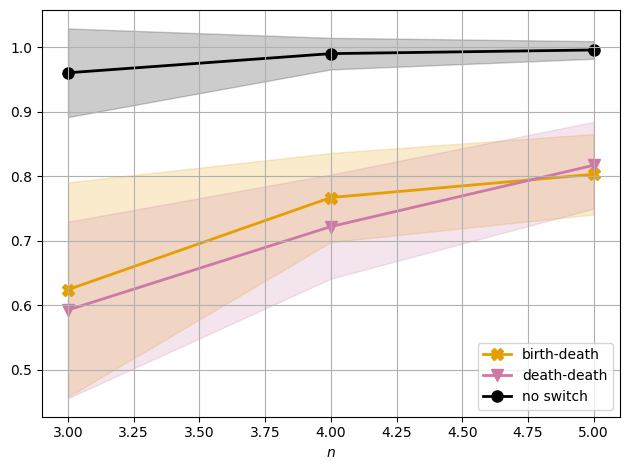

In [21]:
rows = df_scores_mean.columns.to_frame()[['score', 'complex_dim', 'dim']].drop_duplicates().reset_index(drop=True)

for i, (score, complex_dim, dim) in tqdm(rows.iterrows(), total=len(rows)):
    path = os.path.join(path_to_save, picscores_filename_template.format(score=score.replace('_', '-'), complex_dim=complex_dim, dim=dim))

    df_this_mean = df_scores_mean[score][complex_dim][dim]
    df_this_std = df_scores_std[score][complex_dim][dim]

    for col in df_this_mean.columns:
        x = df_this_mean.index.values
        y_mean = df_this_mean[col].values
        y_std = df_this_std[col].values
        plt.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

    plt.grid(True)
    plt.legend()
    plt.xlabel('$n$')
    #plt.ylabel(score)
    plt.tight_layout()
    plt.savefig(path)
    if i < len(rows) - 1:
        plt.close()
plt.show()

In [22]:
figure_1_layer_template = r"""
\begin{{figure}}[htbp]
\centering
{subfigures}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

In [23]:
def latexize(score):
    return score.replace('_', r'\_')

In [24]:
score_label_template = 'fig:{score}complex{complex_dim}'

In [25]:
scores_ltx_pics = []

rows = df_scores_mean.columns.to_frame()[['score', 'complex_dim']].drop_duplicates().reset_index(drop=True)

for irow, (score, complex_dim) in rows.iterrows():
    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures = []
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, picscores_filename_template.format(score=score.replace('_', '-'), complex_dim=complex_dim, dim=dim))
        path = path.replace(r'raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:{score.replace('_', '')}complex{complex_dim}cells{dim}'
        subfigures.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    subfigures = '\n\\hfill\n'.join(subfigures)
    caption = f'Similarity score {latexize(score)} for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = score_label_template.format(complex_dim=complex_dim, score=score.replace('_', ''))
    scores_ltx_pics.append(figure_1_layer_template.format(subfigures=subfigures, caption=caption, label=label))
scores_ltx_pics = '\n\n'.join(scores_ltx_pics)

In [26]:
score_item_template = """
\\item \\textbf{{{score}}} - {descr}
""".strip()

scores_ltx_descr = [score_item_template.format(score=latexize(score), descr=getattr(depth_poset_similarity_scores, score).__doc__.strip()) for score in scores]
scores_ltx_descr = '\n'.join(scores_ltx_descr)
scores_ltx_descr = f"""
\\begin{{itemize}}
{scores_ltx_descr}
\\end{{itemize}}
""".strip()

print(scores_ltx_descr)

\begin{itemize}
\item \textbf{birth\_relation\_cell\_similarity} - The Jacard index of arcs (edges) in the birth relation (given by row left to right reduction algorithm).
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{death\_relation\_cell\_similarity} - The Jacard index of arcs (edges) in the death relation (given by column bottom to top reduction algorithm).
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{poset\_closure\_arcs\_cell\_similarity} - The Jacard index of arcs (edges) in the transitive closure of the Depth Posets.
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{poset\_reduction\_arcs\_cell\_similarity} - The Jacard index of arcs (edges) in the transitive reduction of the Depth Posets.
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\end{itemize}


In [27]:
df_scoredim_status = df.groupby('complex_dim')[scores].count() > 0

df_scoredim = pd.DataFrame([[score_label_template.format(complex_dim=dim, score=score.replace('_', '')) for score in df_scoredim_status.columns] for dim in df_scoredim_status.index], 
                           columns=df_scoredim_status.columns, index=df_scoredim_status.index).map(lambda ref: f'Fig. \\ref{{{ref}}}')
df_scoredim.where(df_scoredim_status, '', inplace=True)

df_scoredim.index.name = 'dim'
df_scoredim = df_scoredim.rename(columns=latexize)

df_scoredim

,birth\_relation\_cell\_similarity,death\_relation\_cell\_similarity,poset\_closure\_arcs\_cell\_similarity,poset\_reduction\_arcs\_cell\_similarity
dim,,,,
1,Fig. \ref{fig:birthrelationcellsimilaritycompl...,Fig. \ref{fig:deathrelationcellsimilaritycompl...,Fig. \ref{fig:posetclosurearcscellsimilarityco...,Fig. \ref{fig:posetreductionarcscellsimilarity...
2,Fig. \ref{fig:birthrelationcellsimilaritycompl...,Fig. \ref{fig:deathrelationcellsimilaritycompl...,Fig. \ref{fig:posetclosurearcscellsimilarityco...,Fig. \ref{fig:posetreductionarcscellsimilarity...


In [34]:
scores_ltx_table = f"""
\\par The distribution of the similarity scores for different models $\\mathbb{{T}}^{{dim}}_n$ we can see in the following figures:

{df_scoredim.transpose().to_latex()}
""".strip()

print(scores_ltx_table)

\par The distribution of the similarity scores for different models $\mathbb{T}^{dim}_n$ we can see in the following figures:

\begin{tabular}{lll}
\toprule
dim & 1 & 2 \\
\midrule
birth\_relation\_cell\_similarity & Fig. \ref{fig:birthrelationcellsimilaritycomplex1} & Fig. \ref{fig:birthrelationcellsimilaritycomplex2} \\
death\_relation\_cell\_similarity & Fig. \ref{fig:deathrelationcellsimilaritycomplex1} & Fig. \ref{fig:deathrelationcellsimilaritycomplex2} \\
poset\_closure\_arcs\_cell\_similarity & Fig. \ref{fig:posetclosurearcscellsimilaritycomplex1} & Fig. \ref{fig:posetclosurearcscellsimilaritycomplex2} \\
poset\_reduction\_arcs\_cell\_similarity & Fig. \ref{fig:posetreductionarcscellsimilaritycomplex1} & Fig. \ref{fig:posetreductionarcscellsimilaritycomplex2} \\
\bottomrule
\end{tabular}


In [35]:
scores_ltx = f"""
{scores_ltx_descr}
{scores_ltx_table}
{scores_ltx_pics}
"""

# Compile report

In [36]:
# load texts, describing the process
with open('texts/extended-barycentric-cubical-torus-transpositions - descr.txt', 'r') as file:
    s_descr = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    ltx_latex = file.read()

In [37]:
body = f"""
\\section{{Description}}
{s_descr}
\\newpage

\\section{{Switch Types Distributions}}
{switch_type_distributions_ltx}
\\newpage

\\section{{Similarity Scores}}
{scores_ltx}

"""

raport = ltx_latex.replace('BODY', body)

In [38]:
with open('raports/extended-barycentric-torus-transpositions.tex', 'w') as file:
    file.write(raport)


In [39]:
os.chdir('raports')
result = subprocess.run(
    ['pdflatex', 'extended-barycentric-torus-transpositions.tex'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)
os.chdir('..')